# Thermal management of a building

Objective: compare different approaches for the *approximate optimal control* of a simple thermal system.
In particular, test the rollout approach.

![block diagram of the thermal system with control](thermal_sys.png)

Optimal solution from linear programming is in a dedicated notebook: [thermal_linprog.ipynb](thermal_linprog.ipynb)

PH,  April-May 2016

In [1]:
from __future__ import division, unicode_literals, print_function
import numpy as np
from ipywidgets import interact

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mpl.style.use(['seaborn-deep', 'seaborn-whitegrid', 'seaborn-notebook'])
mpl.rcParams['figure.figsize'] = [8, 3.5]  # thin plots for time series

## Problem definition

The thermal system is a first order model of a single room with a heater.

![equivalent electrical circuit of the thermal model](therm_diagram.png)


### Dynamics

thermal dynamics (1st order) in continuous time:

$$C \frac{dT}{dt} = P - \frac{T-T_{out}}{R} $$

with parameters:

* $C$: thermal capacity (J/K)
* $R$: thermal resistance of the wall (loss factor with the outside) (K/W)
 
variables:
* $T$: room temperature (state variable that we want to control)
* $T_{out}$: outside temperature (external perturbation for the room temperature)
* $P$: heating power (control variable)

### Control objective

Objective:

* minimize the energy consumption $\int P dt$ on a long term horizon
* while satisfying a constraint on thermal comfort $T(t) \geq T_{min}(t)$

with actuator constraint:

* heating power is limited, and no cooling is possible: $0 \leq P \leq \ P_{max}$



In effect, $T_{min}$ is the temperature setpoint, but interpreted as a lower bound constraint, because the satisfaction of confort is highly asymetrical (penalty for $T<T_{min}$).

### Parameters values

choice of units: hours, kW, Celsius degrees.

In [4]:
from therm_data import dt, C, R, P_max

In [5]:
print('Timestep dt: {} h'.format(dt))
print('Capacity C: {} kWh/K'.format(C))
print('Resistance R: {} °C/kW'.format(R))
print('P_max: {} kWh'.format(P_max))

Timestep dt: 0.1 h
Capacity C: 1 kWh/K
Resistance R: 20 °C/kW
P_max: 3 kWh


Thermal time constant

In [6]:
R*C # hours

20

max Temperature ramp-up (°/h): $dT/dt = P/C$ when no losses

In [7]:
P_max/C

3.0

Number of simulation pts: 24 hours

In [8]:
N_sim = int(24/dt)

dynamics in discrete time (backward Euler), with timestep $\Delta_t$ :

$$T^+ = T + \frac{\Delta_t}{C} ( P - \frac{T-T_{out}}{R} ) $$

In [9]:
def dyn_th(T, T_out, P):
    'thermal dynamics'
    T_next = T + dt/C*(P - (T-T_out)/R)
    return T_next

### Empirical control laws

Empirical control laws are used in the rollout approach for the future decisions (after the present instant which is optimized). For now we have:

* [Linear feedback](#Linear-feedback)
* [Empirical predictive control](#Empirical-predictive-control)

All control functions should take 3 arguments:

* `T`: scalar, present temperature `T` (state feedback)
* `T_min_fcast`: array, present and forecasted request of min temperature (set point).
* `T_out`: scalar, present outdoor temperature (perturbation). *This might changed into a forecast in a future version*

#### Linear feedback

*A simple control, quite good for temperature tracking, but no anticipative power*

Formula: heating power is propostional to the temperature difference with setpoint:

$$ P = K (T_{min} - T)$$

with a big value of gain $K$ and saturation of heating power.

About the tuning of gain $K$:

* should be the highest possible to reduce steady-state error ($T_{min} - T = P/K = (T-T_{out})/(KR)$)
* 10 is stable, but 20 is not. 

→ choose $K$ =10 kW/°. Yields typically 0.1 °C of steady state error (for $T-T_{out}$ = 20 °C)

In [11]:
def sat(P):
    'saturate power between [0, P_max]'
    Ps = P
    if P <0:
        Ps = 0
    if P > P_max:
        Ps = P_max
    return Ps

def ctrl_lin(T, T_min_fcast, T_out):
    'simple linear control of heat, with saturation [0, P_max]'
    K = 10 # kW/°
    T_min = T_min_fcast[0]
    P = K * (T_min-T)
    return sat(P)

#### Empirical predictive control

*a simple heuristic way to add anticipative power to the controller, based on energy conservation principle*

Design idea: 

If, for any prediction horizon $h$, the future temperature needs require a change of thermal energy $C (T(k+h)-T(k))$ greater than the maximal output on that horizon ($P_{max}× h \Delta_t$), then start heating at full power: $P = P_{max}$.

Else, use the linear control above.

See below for the effect of parameter `P_max_emppred`.

In [12]:
P_max_emppred = P_max*1.1

def ctrl_emppred(T, T_min_fcast, T_out):
    'simple predictive control of heating'
    P_pred = (T_min_fcast - T_out)/R # steady state heating
    horiz = np.arange(1, len(T_min_fcast)+1)*dt
    P_pred += C*(T_min_fcast - T)/horiz # ramp up heating
    
    P_pred_max = np.max(P_pred)
    
    if P_pred_max > P_max_emppred:
        P = P_max
    else:
        P = ctrl_lin(T, T_min_fcast, T_out)
    return P

### Simulation routine

In [13]:
def sim(T_init, T_out, T_min, ctrl):
    '''Simulation routine
    
    Parameters: 
    * T_init, T_out, T_min: 1d arrays of same length (N_sim)
    * ctrl: control function
    '''
    N_sim = len(T_out)
    T = np.zeros(N_sim)
    T[0] = T_init
    P = np.zeros(N_sim)
    # simulation loop:
    for k in range(N_sim):
        Np = min(int(5/dt), N_sim-k)
        T_min_fcast = T_min[k:k+Np]
        P[k] =  ctrl(T[k], T_min_fcast, T_out[k])
        if (k+1)<N_sim:
            T[k+1] = dyn_th(T[k], T_out[k], P[k])
    return T, P

#### Temperature profiles

Temperature set points are based on occupancy:
    
* presence in the morning 6:30 to 8:00
* presence in the evening: 18:00 to 22:00

Temperature set point:

* 18°C when absent
* 22°C when present

Outside temperature: 2°C

In [14]:
from therm_data import T0, T_out, occupancy, T_abs, T_pres

In [15]:
t = np.arange(N_sim)*dt
occ = occupancy(t)

T_min_traj = np.zeros(N_sim) + T_abs # °C
T_min_traj[occ] = T_pres

T_out_traj = np.zeros(N_sim) + T_out # °C

Test the simulation routine

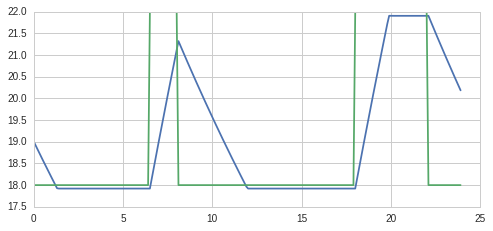

In [16]:
T_traj, P_traj = sim(T0, T_out_traj, T_min_traj, ctrl_lin)

plt.plot(t, T_traj)
plt.plot(t, T_min_traj);

Steady state error at 21h: indeed 0.1 °C

In [17]:
T_min_traj[210]-T_traj[210]

0.099502487562190822

### Optimal solution from linear programming

solution generated in notebook [commande_pred.ipynb](commande_pred.ipynb)

In [26]:
lpsol = np.load("thermal_lp_sol.npz")
lpsol.keys()

['T_min', 'P', 'T_out', 'T']

In [27]:
lp_T = lpsol['T']
lp_T_min = lpsol['T_min']
lp_P = lpsol['P']

In [28]:
assert (lp_T_min == T_min_traj).all()

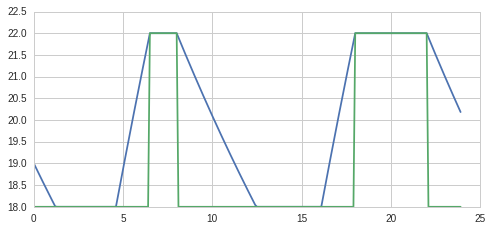

In [29]:
plt.plot(t, lp_T)
plt.plot(t, lp_T_min);

## Cost functions for optimal control

Two competing objectives:

* comfort
* energy consumtion

the eiter comfort can be used as a constraint, or it can be used as a penalty

$$J = J_{energy} + \alpha J_{comfort}$$

where $\alpha$  is the penalty weight (`comfort_weight` in the code), in units of kW/°

Pseudo-theoretical analysis of $\alpha$ choice:

The steady state relation

$$ P = \frac{T - T_{out}}{R}$$

shows a physical tradeoff between heating and comfort with a factor $-1/R$. So "in some sense", $\alpha$ should be (much?) greater than 1/R, that is 0.05 kW/°.

Anyway, we start with `comfort_weight=10` kW/° (which also gives good result with the [relaxed LP](thermal_linprog.ipynb#Relaxation-of-the-min-temperature-constraint)).

In [30]:
def cost_comfort(T, T_min, avg=False):
    '''indicator of the violation of the (T ≥ T_min) constraint
    J= integral of degrees below T_min (°C.hours) or mean (°C)
    '''
    T_diff = np.asarray(T_min-T)
    T_diff[T_diff<0] = 0
    if avg:
        return np.mean(T_diff)
    else:
        return np.sum(T_diff)*dt

In [31]:
def cost_energy(P, avg=False):
    '''energy consumption
    J = integral of heating power (kW.hours)'''
    if avg:
        return np.mean(P)
    else:
        return np.sum(P)*dt

In [32]:
comfort_weight_global=10

def cost(T, T_min, P, comfort_weight=comfort_weight_global, avg=False):
    '''combined cost, with adjustable confort weight factor (kW/°)'''
    return cost_energy(P, avg) + comfort_weight*cost_comfort(T, T_min, avg)

Pretty print function to showcase the result

In [33]:
def print_costs(T, T_min, P):
    '''compute the costs and pretty print them'''
    ccom = cost_comfort(T, T_min, avg=True)
    print('comfort violation: {:.3f} °C avg'.format(ccom))
    cener = cost_energy(P, avg=True)
    print('energy consum: {:.3f} kW avg'.format(cener))
    c = cost(T, T_min, P, avg=True)
    print('energy consum: {:.2f} (with confort weight 10 kW/°)'.format(c))

Quick comparison of the two empirical controls,  and optimal LP result:

In [34]:
T_traj, P_traj = sim(T0, T_out_traj, T_min_traj, ctrl_lin)
print_costs(T_traj, T_min_traj, P_traj)

comfort violation: 0.381 °C avg
energy consum: 0.900 kW avg
energy consum: 4.71 (with confort weight 10 kW/°)


In [35]:
T_traj, P_traj = sim(T0, T_out_traj, T_min_traj, ctrl_emppred)
print_costs(T_traj, T_min_traj, P_traj)
print('(for P_max_emppred = {} P_max)'.format(P_max_emppred/P_max))

comfort violation: 0.058 °C avg
energy consum: 0.931 kW avg
energy consum: 1.51 (with confort weight 10 kW/°)
(for P_max_emppred = 1.1 P_max)


In [36]:
print_costs(lp_T, lp_T_min, lp_P)

comfort violation: 0.000 °C avg
energy consum: 0.939 kW avg
energy consum: 0.94 (with confort weight 10 kW/°)


Conclusion on empirical controls:

* better confort with emperical pred control (discomfort on the order of the steady state error (0.1 °C) of the linear control used during steady state phases)
* but slightly more energy consumption.

Cost scalarization: with a weight of 10 kW/° for confort, the empirical predictive control clearly wins.

LP achieves perfect comfort, with a another slight increase in consumtion. Scalarized cost is the best.

### Visualization: bi-objective tradeoff plot

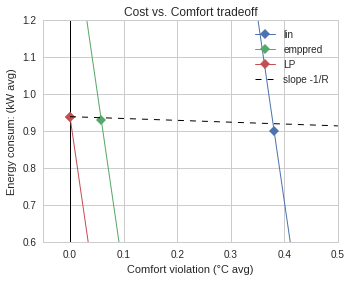

In [37]:
def tradeoff_plot():
    '''compute the confort and energy cost and put them on a plot
    '''
    fig, ax = plt.subplots(figsize=(5,4))
    ax = plt.gca()
    ax.vlines(0, 0, 10, lw=1)
    ax.set(
        xlabel='Comfort violation (°C avg)',
        ylabel='Energy consum: (kW avg)',
        ylim=(0.6,1.2),
        xlim=(-0.05, 0.5),
        title='Cost vs. Comfort tradeoff'
    )
    return fig, ax

def tradeoff_append(ax, T, T_min, P, label):
    '''add cost point corresponding to trajectory `T`, `T_min`, `P` '''
    ccom = cost_comfort(T, T_min, avg=True)
    cener = cost_energy(P, avg=True)
    c = cener + comfort_weight_global*ccom
    
    ax.plot([c/comfort_weight_global,  ccom, 0],
             [0, cener, c], 'D-',
             label=label,
             lw=1)
    ax.legend()

fig, ax = tradeoff_plot()

T_traj, P_traj = sim(T0, T_out_traj, T_min_traj, ctrl_lin)
tradeoff_append(ax, T_traj, T_min_traj, P_traj, 'lin')

T_traj, P_traj = sim(T0, T_out_traj, T_min_traj, ctrl_emppred)
tradeoff_append(ax, T_traj, T_min_traj, P_traj, 'emppred')

tradeoff_append(ax, lp_T, lp_T_min, lp_P, 'LP')

ax.plot([0, 0.5], [0.939, 0.939-0.5/R], 'k--', lw=1, label='slope -1/R')
ax.legend()
fig.tight_layout();

Observations on the cost tradeoff plot:

* the consumption is very close for all controls (due to cold outside temperature of 2°C)
* better comfort comes with a slight increase of consumption, on the order of $\Delta T_{discomfort}/R$ (but greater, because anticipation and inertia lead to some overheating when room is unoccupied)

### Plotting

trajectory plotting, for different controls

In [56]:
def plot_traj(t, T, T_out, T_min, P):
    'plot of a simulation along time (temperature and heating)'
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,4))
    
    ax1.plot(t, T_min, '--', label='T_min')
    ax1.plot(t, T, label='T')
    ax1.legend(loc='upper left')
    
    ax2.plot(t, P, 'r')

    ax1.set(
        ylabel='Temp (°C)'
    )
    ax2.set(
        xlabel='t (h)',
        ylabel='P (kW)',
        ylim=(P_max*-.05, P_max*1.05)
    )
    fig.tight_layout()
    
    return fig, (ax1, ax2)

In [57]:
ctrl_family = {
    'linear feedback':ctrl_lin,
    'empirical predictive':ctrl_emppred
}

def show_ctrl(ctrl_name='linear feedback', T_out=2, ret_fig=False):
    'show the trajectory of one controller'
    # simulation
    ctrl = ctrl_family[ctrl_name]
    T_out_traj = np.zeros(N_sim) + T_out
    T_traj, P_traj = sim(T0, T_out_traj, T_min_traj, ctrl)
    # costs
    ccom = cost_comfort(T_traj, T_min_traj, avg=True)
    cener = cost_energy(P_traj, avg=True)
    c = cost(T_traj, T_min_traj, P_traj, avg=True)
    # plot
    fig, (ax1, ax2) = plot_traj(t, T_traj, T_out_traj, T_min_traj, P_traj)
    ax1.set_ylim(17.5, 22.5)
    title='''Control: {}
    costs: {:.3f} °C, {:.3f} kW, {:.2f}
    '''.format(ctrl_name, ccom, cener, c)
    ax1.set_title(title)
    
    if ret_fig:
        return fig, (ax1, ax2)

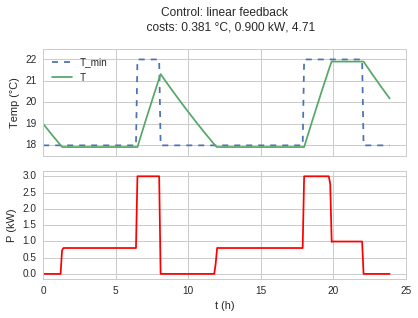

In [59]:
fig, _ = show_ctrl('linear feedback', ret_fig=True);
fig.savefig('sim_Prop_fback.pdf')

#### Interactive trajectory plot

* compare empirical controls
* effect of outside temperature

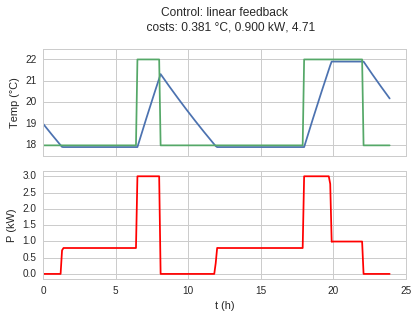

In [41]:
interact(show_ctrl,
         ctrl_name=ctrl_family.keys(),
         T_out=[-10, 20, 2]);

#### Effect of the power thresholp in the empirical predictive control

* if `P_max_emppred` is lower than actual $P_{max}$, pre-heating starts too early (→ extra heating cost) and there is **chattering**
* if if `P_max_emppred` is lower than actual $P_{max}$, pre-heating starts too early (→ extra heating cost) and chatters is higher than actual $P_{max}$, pre-heating starts too late (→ increase in comfort penalty)

Therefore, `P_max_emppred` = 1.1 $P_{max}$ is a nice tradeoff (zero chattering, small comfort penaly).

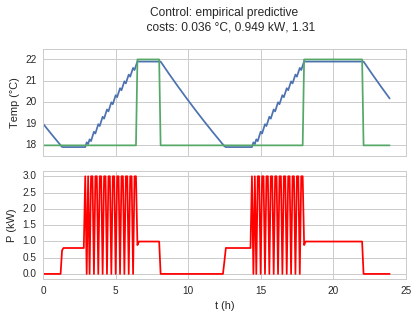

In [42]:
P_max_emppred = 0.7*P_max
show_ctrl('empirical predictive');

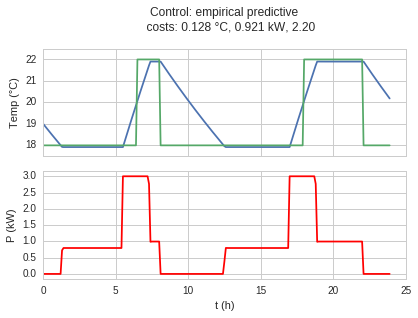

In [43]:
P_max_emppred = 1.5*P_max
show_ctrl('empirical predictive');

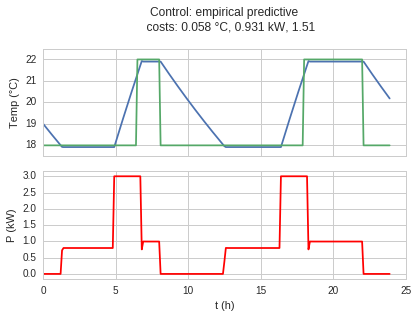

In [44]:
P_max_emppred = 1.1*P_max # value used everywhere else
show_ctrl('empirical predictive');